# Figure 7: Outbreak probability results

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

### Importing required libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pylab as plt
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import fsolve
import multiprocessing as mp
import math
import scipy.stats as stats

### Importing required scripts

In [2]:
import importlib
import Gillespie_household_model
import Keeling_model
import R_star_construct
import Offspring_dist_neighbourhoods
import Offspring_dist_construction

importlib.reload(Gillespie_household_model)
importlib.reload(Keeling_model)
importlib.reload(R_star_construct)
importlib.reload(Offspring_dist_neighbourhoods)
importlib.reload(Offspring_dist_construction)

do_Gillespie = Gillespie_household_model.do_Gillespie
ConfigsConstruct = Keeling_model.ConfigsConstruct
Rstar = R_star_construct.Rstar
RstarAnal = R_star_construct.RstarAnal
Gen_func_s_neigh = Offspring_dist_neighbourhoods.Gen_func_s_neigh
Gen_func_s = Offspring_dist_construction.Gen_func_s

### Parameters

In [3]:
h1,h2 = 840,2520             # no. of households in each neighbourhood
n1,n2 = 6,2                  # size of households for each neighbourhood
gamma = 0.2                  # recovery rate from infection
pop_size = h1*n1 + h2*n2     # total population size   
days = 100    # no. of days in simulation
tStart, tEnd = 0, days       # start time and end time (days) of simulation
time_points = np.linspace(tStart, tEnd, days+1)  # time points for Gillespie output, daily
chains = 50000               # no. of runs of SSA

In [4]:
## constructing rho

N_neigh = 2               # no. of neighbourhoods
H = np.array([h1,h2])     # array of number of households in each neighbourhood
N = np.array([n1,n2])     # array of household size for each neighbourhood

p_reserve = np.array([0,0])            # proportion of contacts reserved for own neighbourhood
rho = np.zeros((N_neigh,N_neigh))      # initialising array to store rho values

for i in range(N_neigh): 
    for j in range(N_neigh):
        rho[i,j] = (1-p_reserve[i])*(1-p_reserve[j])*H[j]*N[j]/(np.sum((1-p_reserve)*H*N))
    rho[i,i] = p_reserve[i] + (1-p_reserve[i])*(1-p_reserve[i])*H[i]*N[i]/(np.sum((1-p_reserve)*H*N))

In [5]:
## fixing contact rates alpha and beta

nu = 3     # good range 1 to 6 (2 to 4)
beta = fsolve(RstarAnal,0.5,(gamma,nu))[0]  # solving for beta when fixing R_* to 2.4
alpha = beta/nu                             # beta = nu*alpha

alpha=round(alpha,2)                        # truncating to 2 d.p.
beta=round(beta,2)
alpha,beta

(0.27, 0.8)

In [6]:
nVar = [2,3,4,5,6]                # list of household sizes for neighbourhood 1     
hVar = [2520,1680,1260,1008,840]  # no. of households
h2 = 2520             # no. of households in neighbourhood 2
n2 = 2                # household size neighbourhood 2
binwidth = 1          # bin width used to store gillespie output data in histogram form
configs2,n_configs2 = ConfigsConstruct(n2)   #poss configurations and no. of them for neighbourhood 2 households

### Calculate outbreak probabilities for initial infected individual from neighbourhood 1

In [7]:
Inf1,Inf2 = 1,0              # initial no. of infections in each neighbourhood

no_out_prob = np.zeros(len(hVar))    # initialising array for outbreak probability found using gillespie sims
ss = np.zeros(len(hVar))             # initialising array to store outbreak probability found analytically

for m in range(len(hVar)):  # looping over the different household sizes for neighbourhood 1
    h1 = hVar[m]
    n1 = nVar[m]
    configs1,n_configs1 = ConfigsConstruct(n1)  # defining the set of household configurations

    y0 = np.zeros(n_configs1+n_configs2)     # state space is each of the possible household configurations accross the 2 neighbourhoods
    y0[0] = (h1 - Inf1)/h1                   # propn of households neighbourhood 1 made up of susceptibles only
    y0[1] = Inf1/h1                          # propn of households neighbourhood 1 with one initial infected
    y0[n_configs1] = (h2 - Inf2)/h2          # propn of households neighbourhood 2 made up of susceptibles only
    y0[n_configs1+1] = Inf2/h2               # propn of households neighbourhood 2 with one initial infected 
    
    params = (n1,n2,beta,alpha,rho[0,0],gamma,y0)             # parameter set
    ss[m] = fsolve(Gen_func_s_neigh,(0.5,0.5), args=params)[0]  # correct BP approximation
    pool = mp.Pool(mp.cpu_count())          # start parallel processing
    
    params_dict = {'beta': [beta, beta],   # parameter dictionary inputted into Gillespie SSA
               'alpha': alpha*rho, 
               'gamma':gamma,
               'n': [n1,n2], 
               'h': [h1,h2],
               'inf0':[Inf1, Inf2],
               'tStart':tStart,
               'tEnd':tEnd,
               'time_points':time_points
              }
    new_results = pool.map(do_Gillespie, [params_dict for i in range(chains)])     # running SSA
    pool.close()
    
    out_size = np.zeros(chains)    # initialise array to store outbreak size from each run

    for i in range(chains):        # loop over runs to unpack results
        hhold_infs = new_results[i]   # unpack each run
        # find entry where both neighbourhoods have finished their outbreaks/ final time point in sim
        ind_infs = np.max(np.hstack((np.nonzero(hhold_infs[:,0]), np.nonzero(hhold_infs[:,1]))))   
        out_size[i] = np.sum(hhold_infs[ind_infs,:])    # final outbreak size accross both neighbourhoods
    # record as histogram i.e. frequencies of each possible outbreak size  after so many runs of SSA
    hist_dat = np.histogram(out_size,bins=range(0, math.ceil(max(out_size)), binwidth))[0]     
    # find second entry where no outbreaks of that size - correpsonds to cutoff before run considered an outbreak
    indx = np.where(hist_dat == 0)[0][2] 
    no_out_prob[m] = np.sum(hist_dat[:indx])/np.sum(hist_dat)   # no outbreak probability estimated from SSA runs

In [8]:
### function that returns incorrect multitype branching process equations to be solved

def eqns_bp(x,*p):
    R_star11,R_star12,R_star21,R_star22 = p
    s1,s2=x
    eqn1 = s1*(1+R_star11*(1-s1)+R_star12*(1-s2))-1
    eqn2 = s2*(1+R_star21*(1-s1)+R_star22*(1-s2))-1
    return(eqn1,eqn2)

### Calculate outbreak probabilities for initial infected individual from neighbourhood 2

In [9]:
Inf1,Inf2 = 0,1              # initial no. of infections in each neighbourhood

no_out_prob2 = np.zeros(len(hVar))  # initialising array for outbreak probability found using gillespie sims
ss2 = np.zeros(len(hVar))           # initialising array to store outbreak probability found analytically
ss1 = np.zeros(len(hVar))           # initialising array to store outbreak probability found using incorrect BP

for m in range(len(hVar)):          # looping over the different household sizes for neighbourhood 1
    h1 = hVar[m]
    n1 = nVar[m]
    configs1,n_configs1 = ConfigsConstruct(n1)  # defining the set of household configurations

    y0 = np.zeros(n_configs1+n_configs2)     # state space is each of the possible household configurations accross the 2 neighbourhoods
    y0[0] = (h1 - Inf1)/h1                   # propn of households neighbourhood 1 made up of susceptibles only
    y0[1] = Inf1/h1                          # propn of households neighbourhood 1 with one initial infected
    y0[n_configs1] = (h2 - Inf2)/h2          # propn of households neighbourhood 2 made up of susceptibles only
    y0[n_configs1+1] = Inf2/h2               # propn of households neighbourhood 2 with one initial infected 
    
    params = (n1,n2,beta,alpha,rho[0,0],gamma,y0)              # parameter set
    ss2[m] = fsolve(Gen_func_s_neigh,(0.5,0.5), args=params)[1]  # correct BP approximation
    R_star,R_star11,R_star12,R_star21,R_star22 = Rstar(n1,n2,beta,beta,alpha,alpha,rho[0,0],rho[1,1],gamma,y0)
    ss1[m] = fsolve(eqns_bp,(0.5,0.5), args=(R_star11,R_star12,R_star21,R_star22))[0]
    pool = mp.Pool(mp.cpu_count())    # start parallel processing
    
    params_dict = {'beta': [beta, beta],   # parameter dictionary inputted into Gillespie SSA
               'alpha': alpha*rho, 
               'gamma':gamma,
               'n': [n1,n2], 
               'h': [h1,h2],
               'inf0':[Inf1, Inf2],
               'tStart':tStart,
               'tEnd':tEnd,
               'time_points':time_points
              }
    new_results = pool.map(do_Gillespie, [params_dict for i in range(chains)])  # running SSA
    pool.close()
    
    out_size = np.zeros(chains)    # initialise array to store outbreak size from each run

    for i in range(chains):   # loop over runs to unpack results
        hhold_infs = new_results[i]       # unpack each run
        # find entry where both neighbourhoods have finished their outbreaks/ final time point in sim
        ind_infs = np.max(np.hstack((np.nonzero(hhold_infs[:,0]), np.nonzero(hhold_infs[:,1]))))
        out_size[i] = np.sum(hhold_infs[ind_infs,:])    # final outbreak size accross both neighbourhoods
    # record as histogram i.e. frequencies of each possible outbreak size  after so many runs of SSA
    hist_dat = np.histogram(out_size,bins=range(0, math.ceil(max(out_size)), binwidth))[0]
    # find second entry where no outbreaks of that size - correpsonds to cutoff before run considered an outbreak
    indx = np.where(hist_dat == 0)[0][2]
    no_out_prob2[m] = np.sum(hist_dat[:indx])/np.sum(hist_dat)  # no outbreak probability estimated from SSA runs

### Producing figure
#### (a), for (b) simply set $\nu =1$

In [10]:
# Assuming no_out_prob, no_out_prob2, ss, and ss2 are NumPy arrays
np.save('no_out_prob.npy', no_out_prob)
np.save('no_out_prob2.npy', no_out_prob2)
np.save('ss.npy', ss)
np.save('ss2.npy', ss2)

In [11]:
# Load the data from the files
no_out_prob = np.load('no_out_prob.npy')
no_out_prob2 = np.load('no_out_prob2.npy')
ss = np.load('ss.npy')
ss2 = np.load('ss2.npy')

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


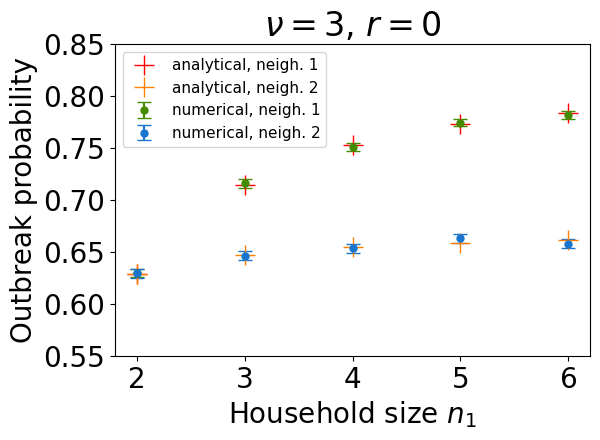

In [12]:
# Calculate the standard error for no_out_prob and no_out_prob2
std_err_no_out_prob = np.sqrt((no_out_prob * (1 - no_out_prob)) / chains)
std_err_no_out_prob2 = np.sqrt((no_out_prob2 * (1 - no_out_prob2)) / chains)

# Calculate the confidence intervals (95% confidence level)
z_score = stats.norm.ppf(1 - 0.05 / 2)
conf_intervals_no_out_prob = std_err_no_out_prob * z_score
conf_intervals_no_out_prob2 = std_err_no_out_prob2 * z_score

plt.rcParams.update({'font.size': 20})

# Plot numerical results with confidence intervals
plt.errorbar(nVar, 1 - no_out_prob, yerr=conf_intervals_no_out_prob, fmt='.', color='#458B00', markersize=10, label='numerical, neigh. 1', capsize=5)
plt.errorbar(nVar, 1 - no_out_prob2, yerr=conf_intervals_no_out_prob2, fmt='.', color='#1874CD', markersize=10, label='numerical, neigh. 2', capsize=5)

# Plot analytical results
plt.plot(nVar, 1 - ss, '+', color='#FF0000', markersize=15, label='analytical, neigh. 1')
plt.plot(nVar, 1 - ss2, '+', color='#FF8000', markersize=15, label='analytical, neigh. 2')

plt.xlabel(r'Household size $n_1$')
plt.ylabel('Outbreak probability')
plt.title(r'$\nu=${}, $r=${}'.format(nu, p_reserve[0]))
plt.xticks([2, 3, 4, 5, 6])
plt.legend(fontsize=11)
plt.ylim(0.55, 0.85)
plt.yticks([0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85])
plt.tight_layout()
#plt.savefig('outbreak_prob_together3.pdf')
plt.show()

#### (c)

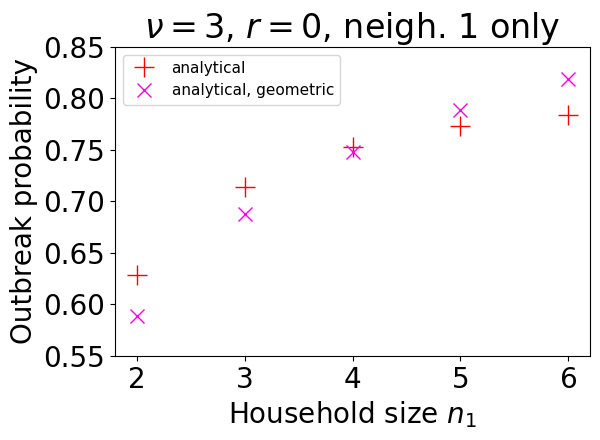

In [13]:
#figure = plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size': 20})
#plt.plot(nVar,1-no_out_prob,'.', color='#458B00', markersize = 15, label='numerical')
plt.plot(nVar,1-ss,'+', color='#FF0000', markersize = 15, label='analytical')
plt.plot(nVar,1-ss1,'x', color='#fc03e3', markersize = 10, label='analytical, geometric')

plt.xlabel(r'Household size $n_1$')
plt.ylabel('Outbreak probability')
plt.title(r'$\nu=${}, $r=${}, neigh. 1 only'.format(nu,p_reserve[0]))
plt.xticks([2,3,4,5,6])
plt.legend(fontsize=11)
plt.ylim(0.55,0.85)
plt.yticks([0.55,0.6,0.65,0.7,0.75,0.8,0.85])
plt.tight_layout()
plt.savefig('outbreak_prob_attempts.pdf')

#### (d)

In [14]:
nVar = [2,3,4,5,6]                       # list of household sizes neighbourhood 1
hVar = [2520,1680,1260,1008,840]         # list of number of households neighbourhood 1
h2 = 2520                                # number of households neighbourhood 2
n2 = 2                                   # household size neighbourhood 2
Inf1,Inf2 = 1,0

# initialise arrays to store various outbreak probabilities
s1 = np.zeros(len(hVar))    # no neighbourhoods, n=6
s2 = np.zeros(len(hVar))    # no neighbourhoods, n=2
ss1 = np.zeros(len(hVar))   # initial case neighbourhood 1
ss2 = np.zeros(len(hVar))   # initial case neighbourhood 2
configs2,n_configs2 = ConfigsConstruct(n2)

for m in range(len(hVar)): # loop over neighbourhood 1 household sizes
    h1 = hVar[m]
    n1 = nVar[m]
    configs1,n_configs1 = ConfigsConstruct(n1)  # defining the set of household configurations

    y0 = np.zeros(n_configs1+n_configs2)     # state space is each of the possible household configurations accross the 2 neighbourhoods
    y0[0] = (h1 - Inf1)/h1                   # propn of households neighbourhood 1 made up of susceptibles only
    y0[1] = Inf1/h1                          # propn of households neighbourhood 1 with one initial infected
    y0[n_configs1] = (h2 - Inf2)/h2          # propn of households neighbourhood 2 made up of susceptibles only
    y0[n_configs1+1] = Inf2/h2               # propn of households neighbourhood 2 with one initial infected 
    R_star,R_star11,R_star12,R_star21,R_star22 = Rstar(n1,n2,beta,beta,alpha,alpha,rho[0,0],rho[1,1],gamma,y0)
    
    params = (n1,n2,beta,alpha,rho[0,0],gamma,y0)     # parameter sets for each generating function
    params_ = (n1,n2,beta,alpha,rho[0,0],gamma,y0)
    params1 = (n1,n2,beta,alpha,rho[0,0],gamma,y0,0,50)
    params2 = (n1,n2,beta,alpha,rho[0,0],gamma,y0,1,50)
    ss1[m] = fsolve(Gen_func_s_neigh,(0.5,0.5), args=params)[0]  # correct BP approximation
    ss2[m] = fsolve(Gen_func_s_neigh,(0.5,0.5), args=params)[1]  # correct BP approximation
    s1[m] = fsolve(Gen_func_s,0.5, args=params1)
    s2[m] = fsolve(Gen_func_s,0.5, args=params2)

#### Producing figure

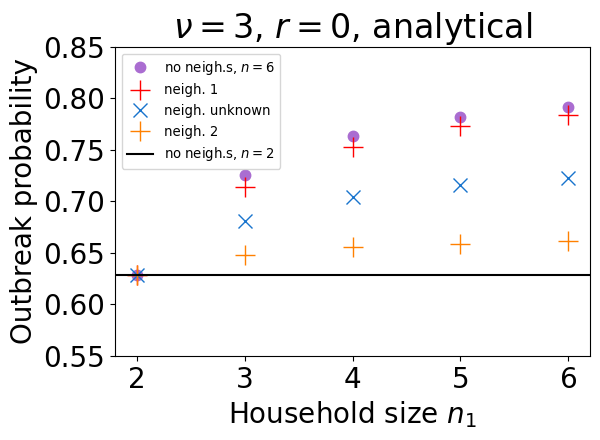

In [15]:
plt.rcParams.update({'font.size': 20})
plt.plot(nVar,1-s1, '.', color = '#AA6DD1', markersize = 15, label='no neigh.s, $n=6$')
plt.plot(nVar,1-ss1,'+', color='#FF0000', markersize = 15, label='neigh. 1')
plt.plot(nVar,((1-ss1)+(1-ss2))/2, 'x', color='#1874CD', markersize = 10, label='neigh. unknown')
plt.plot(nVar,1-ss2,'+', color= '#FF8000', markersize = 15, label='neigh. 2')
plt.axhline(1-s1[0],color='black', label = 'no neigh.s, $n=2$')

plt.xlabel(r'Household size $n_1$')
plt.ylabel('Outbreak probability')
plt.title(r'$\nu=${}, $r=${}, analytical'.format(nu,p_reserve[0]))
plt.xticks([2,3,4,5,6])
plt.yticks([0.55,0.6,0.65,0.7,0.75,0.8,0.85])
plt.tight_layout()
plt.legend(fontsize=9.5)
#plt.savefig('outbreak_prob_surv1.pdf')

The probability of an outbreak occurring originating from a single infectious individual in neighbourhood $1$ (higher curve; green dots and red pluses) and a single individual from neighbourhood $2$ (lower curve; blue dots and orange pluses), as we increase the household size in neighbourhood $1$ from $2$ to $6$. Dots denote outbreak probabilities found via $50,000$ Gillespie SSA realisations; pluses denote the multi-type branching process approximations.
    Household size remains fixed at $n_2=2$ in neighbourhood $2$ and neighbourhood connectivity is proportionate. (a) Contact rate scaling factor is set to $\nu=3$ and (b) contact rate is set to $\nu=1$, such that $\beta=\nu \alpha$ and $R_*=2.4$. (c) Probability of an outbreak occurring originating from a single infectious individual in neighbourhood $1$. For comparison, incorrect branching process approximation shown as green crosses. (d) Probability of an outbreak occurring originating from a single infectious individual: from neighbourhood $1$ (greens dots); from a single neighbourhood population of household size $n_1$ (blue pluses); from unknown neighbourhood (purple stars); from neighbourhood $2$ (red crosses) and from a single neighbourhood population of household size $n_2=2$ (fixed) (orange pluses)